### Hypothesis and Regression Testing for Maximising Revenue for NYC Cab Drivers through Payment Type Analysis

#### Problem Statement:

NYC cab drivers face uncertainty regarding which payment methods lead to higher fare amounts, potentially missing opportunities to maximize their revenue. There is a need to statistically analyze the relationship between payment types and fare pricing to determine whether specific payment methods significantly impact earnings, enabling drivers to make informed decisions about payment preferences to optimize their income. Additionally, regression analysis can help identify which trip characteristics (distance, duration, passenger count) most strongly predict fare amounts, allowing drivers to understand the key factors that drive higher earnings and make strategic decisions about trip selection and routing.


#### Objective:
Our research aims to find whether payment methods have an impact on fare pricing by focusing on the relationship between cash and credit card payment types and fare amount. We will employ A/B hypothesis testing to statistically examine the differences between these two payment methods and determine which generates higher fares for NYC cab drivers. Additionally, we will use regression analysis to identify which trip characteristics (distance, duration, passenger count) most strongly predict fare amounts, providing drivers with comprehensive insights into both payment method preferences and the key factors that drive higher earnings to optimize their revenue strategies.

#### Hypothesis Testing: Research Question
"Which payment method (cash vs. credit card) results in higher average fare amounts for NYC cab drivers without compromising customer satisfaction?"

#### Loading the Dataset

In [1]:
#Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Read the file
df = pd.read_parquet("2023_Yellow_Taxi_Trip_Data_filtered.parquet")
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount
0,01/01/2023 12:32:10 AM,01/01/2023 12:40:36 AM,1.0,0.97,2,9.3
1,01/01/2023 12:55:08 AM,01/01/2023 01:01:27 AM,1.0,1.10,1,7.9
2,01/01/2023 12:25:04 AM,01/01/2023 12:37:49 AM,1.0,2.51,1,14.9
3,01/01/2023 12:03:48 AM,01/01/2023 12:13:25 AM,0.0,1.90,1,12.1
4,01/01/2023 12:10:29 AM,01/01/2023 12:21:19 AM,1.0,1.43,1,11.4


In [5]:
#Rows and columns 
df.shape

(38310226, 6)

In [7]:
#Data types
df.dtypes

tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
payment_type               int64
fare_amount              float64
dtype: object

#### Cleaning and Manipulating data
We can see that the pickup and dropoff date is in object format. We need to convert this to date/time format

In [9]:
#Convert date formats
df['tpep_pickup_datetime'] = pd.to_datetime(
    df['tpep_pickup_datetime'],
    format='%m/%d/%Y %I:%M:%S %p')
df['tpep_dropoff_datetime'] = pd.to_datetime(
    df['tpep_dropoff_datetime'],
    format='%m/%d/%Y %I:%M:%S %p')

In [13]:
#Calculate the duration 
df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']

In [15]:
df['duration']  = df['duration'].dt.total_seconds()/60
df

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,payment_type,fare_amount,duration
0,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,2,9.30,8.433333
1,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1,7.90,6.316667
2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1,14.90,12.750000
3,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1,12.10,9.616667
4,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1,11.40,10.833333
...,...,...,...,...,...,...,...
38310221,2023-12-31 23:04:34,2023-12-31 23:13:58,NaN,1.34,0,12.08,9.400000
38310222,2023-12-31 23:08:15,2023-12-31 23:08:23,NaN,0.00,0,25.98,0.133333
38310223,2023-12-31 23:16:15,2023-12-31 23:30:28,NaN,3.71,0,16.68,14.216667
38310224,2023-12-31 23:21:58,2023-12-31 23:34:29,NaN,5.20,0,19.64,12.516667


We will filter the required fields for further analysis and hypothesis testing

In [17]:
#Filter the required fields
df = df[['passenger_count','payment_type','fare_amount',
'trip_distance','duration']]
df

,passenger_count,payment_type,fare_amount,trip_distance,duration
0,1.0,2,9.30,0.97,8.433333
1,1.0,1,7.90,1.10,6.316667
2,1.0,1,14.90,2.51,12.750000
3,0.0,1,12.10,1.90,9.616667
4,1.0,1,11.40,1.43,10.833333
...,...,...,...,...,...
38310221,NaN,0,12.08,1.34,9.400000
38310222,NaN,0,25.98,0.00,0.133333
38310223,NaN,0,16.68,3.71,14.216667
38310224,NaN,0,19.64,5.20,12.516667


Next we check of missing and duplicate values

In [19]:
#Missing values
df.isna().sum()

passenger_count    1309356
payment_type             0
fare_amount              0
trip_distance            0
duration                 0
dtype: int64

We do see missing values in the passenger_count column. Hence we check if the number of missing values is < 5%(industry benchmark). If yes we will drop the missing data

In [8]:
(1309356/38310226)*100

3.417771537030348

In [21]:
#drop missing values
df.dropna(inplace = True)

We also convert payment_type and passenger_count into integers, as these are categorical variables and may be renamed later in the analysis

In [23]:
#convert payment_type and passenger_count as integers
df['passenger_count'] = df['passenger_count'].astype('int64')  
df['payment_type'] = df['payment_type'].astype('int64') 

In [25]:
#check for duplicate values
df[df.duplicated()]

,passenger_count,payment_type,fare_amount,trip_distance,duration
1679,1,1,6.5,0.71,4.600000
2662,1,1,10.7,2.10,7.350000
2794,1,1,7.2,1.10,5.616667
3383,2,1,5.1,0.75,2.116667
3653,1,1,8.6,1.21,6.166667
...,...,...,...,...,...
38130217,2,1,5.8,0.39,4.100000
38130218,1,1,17.0,2.60,18.133333
38130219,1,1,5.1,0.60,2.716667
38130220,1,1,19.8,3.80,18.050000


There might be duplicate values in the data due to repetition of vendor ID etc. Hence duplicate columns do not contribute to the analysis and need to be dropped

In [27]:
#drop duplicates
df.drop_duplicates(inplace = True)
df.shape

(12925302, 5)

#### Exploratory Data Analysis
In EDA, we first check the distribution of passenger counts by using ‘value_counts’ function

In [29]:
#percentage of passenger count distribution 
df['passenger_count'].value_counts(normalize=True)

passenger_count
1    0.603662
2    0.207079
3    0.071584
4    0.047154
5    0.029201
0    0.020894
6    0.020399
8    0.000016
7    0.000007
9    0.000004
Name: proportion, dtype: float64

We can see that there are zero values in the passenger count and very high values, such as 6+, which are outliers. We have to remove these outliers.

We also look at payment_type distribution and only filter Card and Cash transactions

In [31]:
#percentage of payment type distribution 
df['payment_type'].value_counts(normalize=True)

payment_type
1    7.103728e-01
2    2.472009e-01
4    3.018390e-02
3    1.224227e-02
5    1.547353e-07
Name: proportion, dtype: float64

In [33]:
#select rows based on conditions
df = df[df['payment_type']<3]
df = df[(df['passenger_count']>0)& (df['passenger_count']<6)]
df.shape

(11857562, 5)

 Next, we replace payment_type labels to Cash and Card

In [35]:
#replace payment_type labels to Cash and Card
df['payment_type'].replace([1,2],['Card','Cash'], inplace = True)
df

,passenger_count,payment_type,fare_amount,trip_distance,duration
0,1,Cash,9.3,0.97,8.433333
1,1,Card,7.9,1.10,6.316667
2,1,Card,14.9,2.51,12.750000
4,1,Card,11.4,1.43,10.833333
5,1,Card,12.8,1.84,12.300000
...,...,...,...,...,...
38130196,3,Card,24.0,3.26,25.616667
38130197,5,Cash,30.3,4.68,34.116667
38130203,2,Card,31.0,4.61,33.100000
38130216,1,Cash,24.0,4.54,21.883333


In [37]:
df.describe()

,passenger_count,fare_amount,trip_distance,duration
count,1.185756e+07,1.185756e+07,1.185756e+07,1.185756e+07
mean,1.645264e+00,3.338494e+01,7.135890e+00,2.743963e+01
std,1.028524e+00,1.339838e+02,1.244719e+02,8.203719e+03
min,1.000000e+00,-8.000000e+02,0.000000e+00,-2.824830e+07
25%,1.000000e+00,1.700000e+01,2.170000e+00,1.496667e+01
50%,1.000000e+00,2.650000e+01,4.390000e+00,2.311667e+01
75%,2.000000e+00,4.430000e+01,9.770000e+00,3.410000e+01
max,5.000000e+00,3.869836e+05,1.617261e+05,1.002918e+04


From the above data, we can see there are negative values in fare amount and duration, which cannot be true. We also have huge gaps between percentiles, indicating outliers. Hence, we need to remove negatives and outliers

In [39]:
#removing negative values
df  = df[df['fare_amount']>0]
df  = df[df['trip_distance']>0]
df  = df[df['duration']>0]

We will use Inter Quartile Range function to remove outliers

In [41]:
#IQR calculation
for col in ['fare_amount','trip_distance','duration']:
    q1=df[col].quantile(0.25)
    q3=df[col].quantile(0.75)
    IQR = q3-q1
    
    lower_bound = q1-1.5*IQR
    upper_bound = q3+1.5*IQR

    df = df[(df[col]>=lower_bound) & (df[col]<=upper_bound)]

#### Data Visualization
Time for some visualization! Lets compare relationships for example, how the payment type is distributed between fare amount and trip distance

<function matplotlib.pyplot.show(close=None, block=None)>

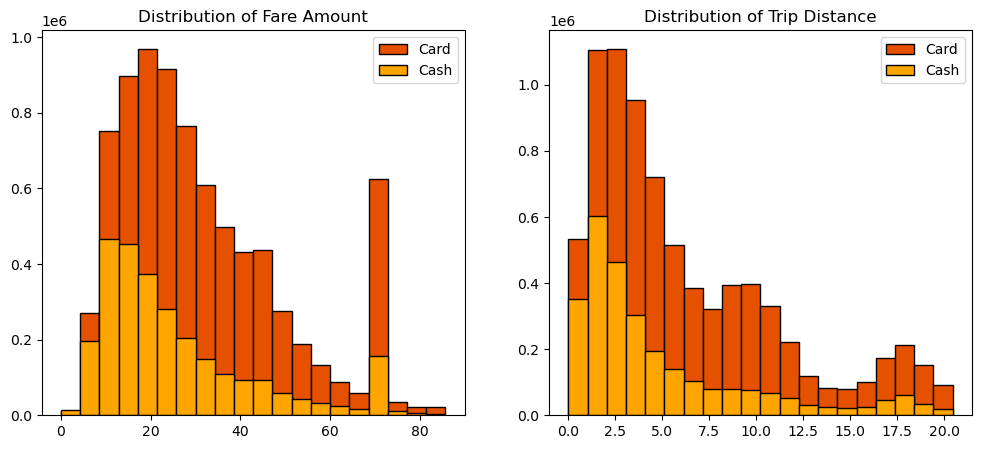

In [43]:
## Visualize payment type dist with fare amount and trip distance
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Distribution of Fare Amount')
plt.hist(df[df['payment_type']=='Card']['fare_amount'], histtype='barstacked',edgecolor='black',bins=20, color = ['#E65100'],label='Card')
plt.hist(df[df['payment_type']=='Cash']['fare_amount'], histtype='barstacked',edgecolor='black',bins=20, color = ['#FFA500'],label='Cash')
plt.legend()

plt.subplot(1,2,2)
plt.title('Distribution of Trip Distance')
plt.hist(df[df['payment_type']=='Card']['trip_distance'], histtype='barstacked',edgecolor='black',bins=20, color = ['#E65100'],label='Card')
plt.hist(df[df['payment_type']=='Cash']['trip_distance'], histtype='barstacked',edgecolor='black',bins=20, color = ['#FFA500'],label='Cash')
plt.legend()
plt.show

In [45]:
#visualize in tabular format
df.groupby('payment_type').agg({'fare_amount':['mean','std'],'trip_distance':['mean','std']})

fare_amount            trip_distance          
                    mean        std          mean       std
payment_type                                               
Card           31.335022  18.041958      6.231315  5.024247
Cash           25.801736  17.521172      4.876044  4.736696

**Summary** - Since the mean and std for card payment is higher, we can infer that as the fare and distance increase, customers prefer paying by card

Now, let's look at percentage distribution of payment types using pie chart

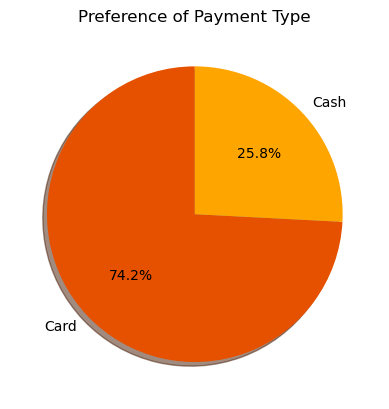

In [47]:
#Pie chart for payment type preference
plt.title('Preference of Payment Type')
plt.pie(df['payment_type'].value_counts(normalize=True),labels = df['payment_type'].value_counts().index,
       startangle = 90, shadow = True, autopct = '%1.1f%%', colors = ['#E65100','#FFA500'])
plt.show()

**Summary** - From the pie chart we can infer that around three fourths of passengers prefer card payment

Another interesting feature is to analyse passenger count analysis using a stacked bar chart

#### Hypothesis Testing
Finally, we apply Hypothess testing to for our hypothesis as stated below:

**Null Hypothesis** = There is no difference in average fare between customers who pay by card and customers who pay by cash

**Alternate Hypothesis** = There is a difference in average fare between customers who pay by card and customers who pay by cash

In [49]:
# Hypothesis Testing t-test
# H0: There is no difference in average fare between card and cash payments
# H1: There is a difference in average fare between card and cash payments

card_sample = df[df['payment_type']=='Card']['fare_amount']
cash_sample = df[df['payment_type']=='Cash']['fare_amount']


# Perform the t-test
t_stats, p_value = st.ttest_ind(a=card_sample, b=cash_sample, equal_var=False)

print('T Statistic:', t_stats)
print(f'P Value: {p_value:.10f}')
print('Card sample mean:', card_sample.mean())
print('Cash sample mean:', cash_sample.mean())
print('Card sample size:', len(card_sample))
print('Cash sample size:', len(cash_sample))

T Statistic: 450.508609439871
P Value: 0.0000000000
Card sample mean: 31.335021755613386
Cash sample mean: 25.801735515151435
Card sample size: 8002992
Cash sample size: 2786239


**Effect Size**

Card payments: $31.34 average fare

Cash payments: $25.80 average fare

Difference: $5.54 higher for card payments (21.5% increase)

**Summary** Since the P value is almost 0.000, which is < 0.05 we can confidently reject the Null hypothesis and agree that customers who pay by card pay higher fares compared to customers who pay by cash. This could be due to various reasons such as longer trips, more passengers etc

#### Regression Testing

Another insightful test is multiple regression analysis to predict the taxi fares based on the trip distance, passenger count and duration

In [51]:
# Import the libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

The next step is to select the Target variable (fare amount) and Dependent variables (passenger count, trip distance and duration)

In [53]:
# Select columns for regression
X = df[['passenger_count', 'trip_distance', 'duration']].copy()
y = df['fare_amount'].copy()

In [55]:
# Remove the null values
data = pd.concat([X, y], axis=1).dropna()
X = data[['passenger_count', 'trip_distance', 'duration']]
y = data['fare_amount']

print("Dataset Info:")
print(f"Number of observations: {len(X)}")
print(f"Features: {list(X.columns)}")
print(f"Target variable: fare_amount")

Dataset Info:
Number of observations: 10789231
Features: ['passenger_count', 'trip_distance', 'duration']
Target variable: fare_amount


Once we select the variables, we split the data into training and testing by assigning 20% for testing and 80% for training

In [57]:
# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)


Training set size: 8631384
Testing set size: 2157847


LinearRegression()

Next, we apply the model and make predictions on the testing data to see how our model performs

In [36]:
# Make predictions on test set
y_pred = model.predict(X_test)

# Calculate performance metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("\n" + "="*50)
print("MODEL PERFORMANCE")
print("="*50)
print(f"R-squared (R²): {r2:.4f}")
print(f"Root Mean Square Error (RMSE): ${rmse:.2f}")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")


MODEL PERFORMANCE
R-squared (R²): 0.9290
Root Mean Square Error (RMSE): $4.81
Mean Absolute Error (MAE): $2.02


**Summary**

The R-squared values show that the model has performed at 93% accuracy, which is a very high success rate. The average fsre variance between training and testing data is around $2 as reflected in the MAE values.

**What does this mean**

- Taxi fares follow very consistent patterns based on dependent variables
- Distance, duration and passenger count capture almost all pricing factors

In [28]:
print("\n" + "="*50)
print("MODEL EQUATION")
print("="*50)
print(f"Intercept: ${model.intercept_:.2f}")
print("\nCoefficients:")
for i, feature in enumerate(X.columns):
    print(f"  {feature}: ${model.coef_[i]:.4f}")

print(f"\nRegression Equation:")
print(f"fare_amount = {model.intercept_:.2f} + " + 
      f"{model.coef_[0]:.4f}×passenger_count + " +
      f"{model.coef_[1]:.4f}×trip_distance + " +
      f"{model.coef_[2]:.4f}×duration")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_,
    'Abs_Coefficient': np.abs(model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nFeature Importance (by impact on fare):")
for idx, row in feature_importance.iterrows():
    print(f"  {row['Feature']}: {row['Coefficient']:.4f}")


MODEL EQUATION
Intercept: $4.47

Coefficients:
  passenger_count: $-0.1101
  trip_distance: $2.7187
  duration: $0.4056

Regression Equation:
fare_amount = 4.47 + -0.1101×passenger_count + 2.7187×trip_distance + 0.4056×duration

Feature Importance (by impact on fare):
  trip_distance: 2.7187
  duration: 0.4056
  passenger_count: -0.1101
